# Model Deployement via FastAPI to GoogleCloud
app folder is created with contents:
1. model.pkl
2. prestart.sh

In [ ]:
export PORT=${AIP_HTTP_PORT:-8000}

3. requirements.txt (model specific libraries and main.py libraries)
4. main.py

In [ ]:
from pydantic import BaseModel
from fastapi import FastAPI
import pandas as pd
import joblib

# Expected input
class Home_Credit(BaseModel):
    EXT_SOURCE_1: float
    NAME_EDUCATION_TYPE: int
    AMT_CREDIT: float
    Max_DURATION_DUE_VERSION: float
    YEARS_EMPLOYED: float
    EXT_SOURCE_3: float
    YEARS_BIRTH: float
    Max_DURATION_DECISION_DRAWING: float
    EXT_SOURCE_2: float
    Min_RATIO_GOODS_PRICE_CREDIT: float
    AVG_Risk_Score: float
    Min_DURATION_DECISION_DRAWING: float
    CODE_GENDER_F: float
    YEARS_LAST_PHONE_CHANGE: float


# Expected output
class PredictionOut(BaseModel):
    default_proba: float


#model = GaussianNB(var_smoothing=1e-09)
model = joblib.load("app\model.pkl")

app = FastAPI()


# Home page
@app.get("/")
def home():
    return {"message": "HomeCredit Default App", "model_version": 0.1}



# Inference endpoint
@app.post("/predict", response_model=PredictionOut)
def predict(payload: Home_Credit):
    cust_df = pd.DataFrame([payload.model_dump()])
    predictions = model.predict_proba(cust_df)[0, 1]

    adjusted_predictions = (predictions > 0.12).astype(int)

    result = {"default_proba": adjusted_predictions}
    return result

# FastAPI to specify API for inference endpoint
1. Model enviroment was Anaconda based. In Anaconda prompt:

In [ ]:
conda activate <ENV_name>
cd <work_folder_directory>
uvicorn app.main:app --host 0.0.0.0 --port 80

2. Open: http://localhost/docs#/ <br>
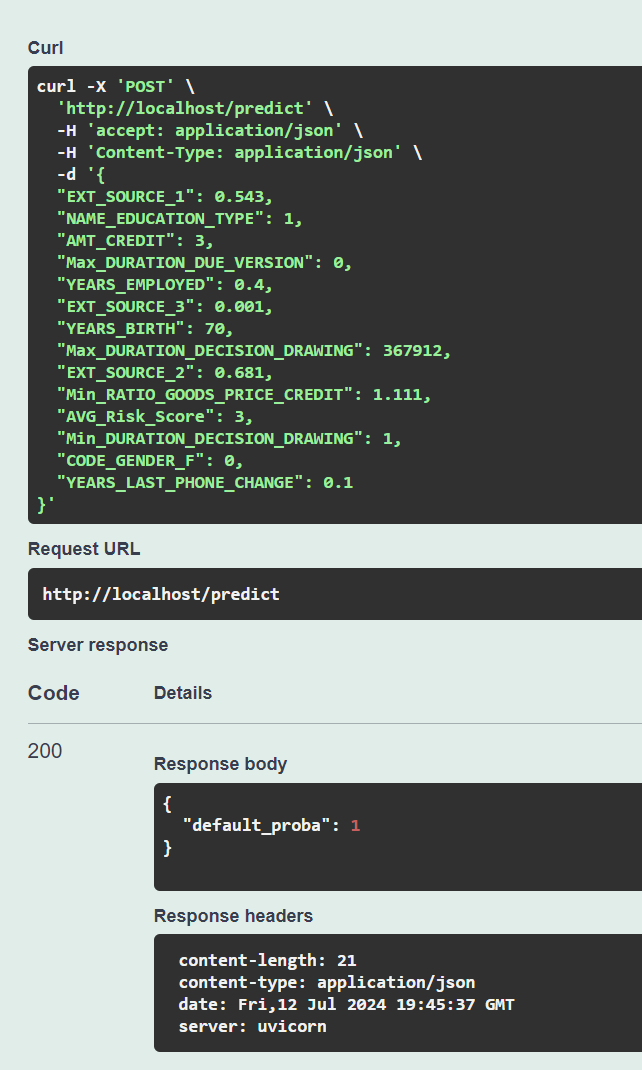

# Containerise the endpoint using Docker
1. Create Dockerfile and place it in <work_folder_directory>

In [ ]:
FROM tiangolo/uvicorn-gunicorn-fastapi:python3.11

COPY ./app /app

RUN pip install -r requirements.txt

# Build the Docker Image
1. In CommandPrompt:

In [ ]:
docker build -t home-default-risk:latest .

2. Open Docker Desctop and check image is running without errors locally.

# Add the Image to Google Artifact Registry
1. Create Repo in GCP Registry
2. Command Prompt

In [ ]:
docker tag home-default-risk europe-west2-docker.pkg.dev/glossy-reserve-429112-u9/home-credit-default-risk-rep/home-default-risk

docker push europe-west2-docker.pkg.dev/glossy-reserve-429112-u9/home-credit-default-risk-rep/home-default-risk

# Deploy Container on Google Cloud Run
1. Go to Registry, find the pushed image and press 'Cloud Deploy'. Choose 8000, instead of 8080. 
* Port must be same as prestart.sh

# Test the Deployment
1. Create app_test.py in  <work_folder_directory>

In [ ]:
from locust import HttpUser, task, constant_throughput

# Define test json request
test_application = {
    "EXT_SOURCE_1": 0.543,
    "NAME_EDUCATION_TYPE": 1,
    "AMT_CREDIT": 3,
    "Max_DURATION_DUE_VERSION": 0,
    "YEARS_EMPLOYED": 0.4,
    "EXT_SOURCE_3": 0.01,
    "YEARS_BIRTH": 70,
    "Max_DURATION_DECISION_DRAWING": 367912,
    "EXT_SOURCE_2": 0.681,
    "Min_RATIO_GOODS_PRICE_CREDIT": 1.111,
    "AVG_Risk_Score": 3,
    "Min_DURATION_DECISION_DRAWING": 1,
    "CODE_GENDER_F": 0,
    "YEARS_LAST_PHONE_CHANGE": 0.1,
}


class CreditScoringUser(HttpUser):
    # Means that a user will send 1 request per second
    wait_time = constant_throughput(1)
    
    # Task to be performed (send data & get response)
    @task
    def predict(self):
        self.client.post(
            "/predict",
            json=test_application,
            timeout=1,
        )

2. In Anaconda prompt:

In [ ]:
locust -f app_test.py

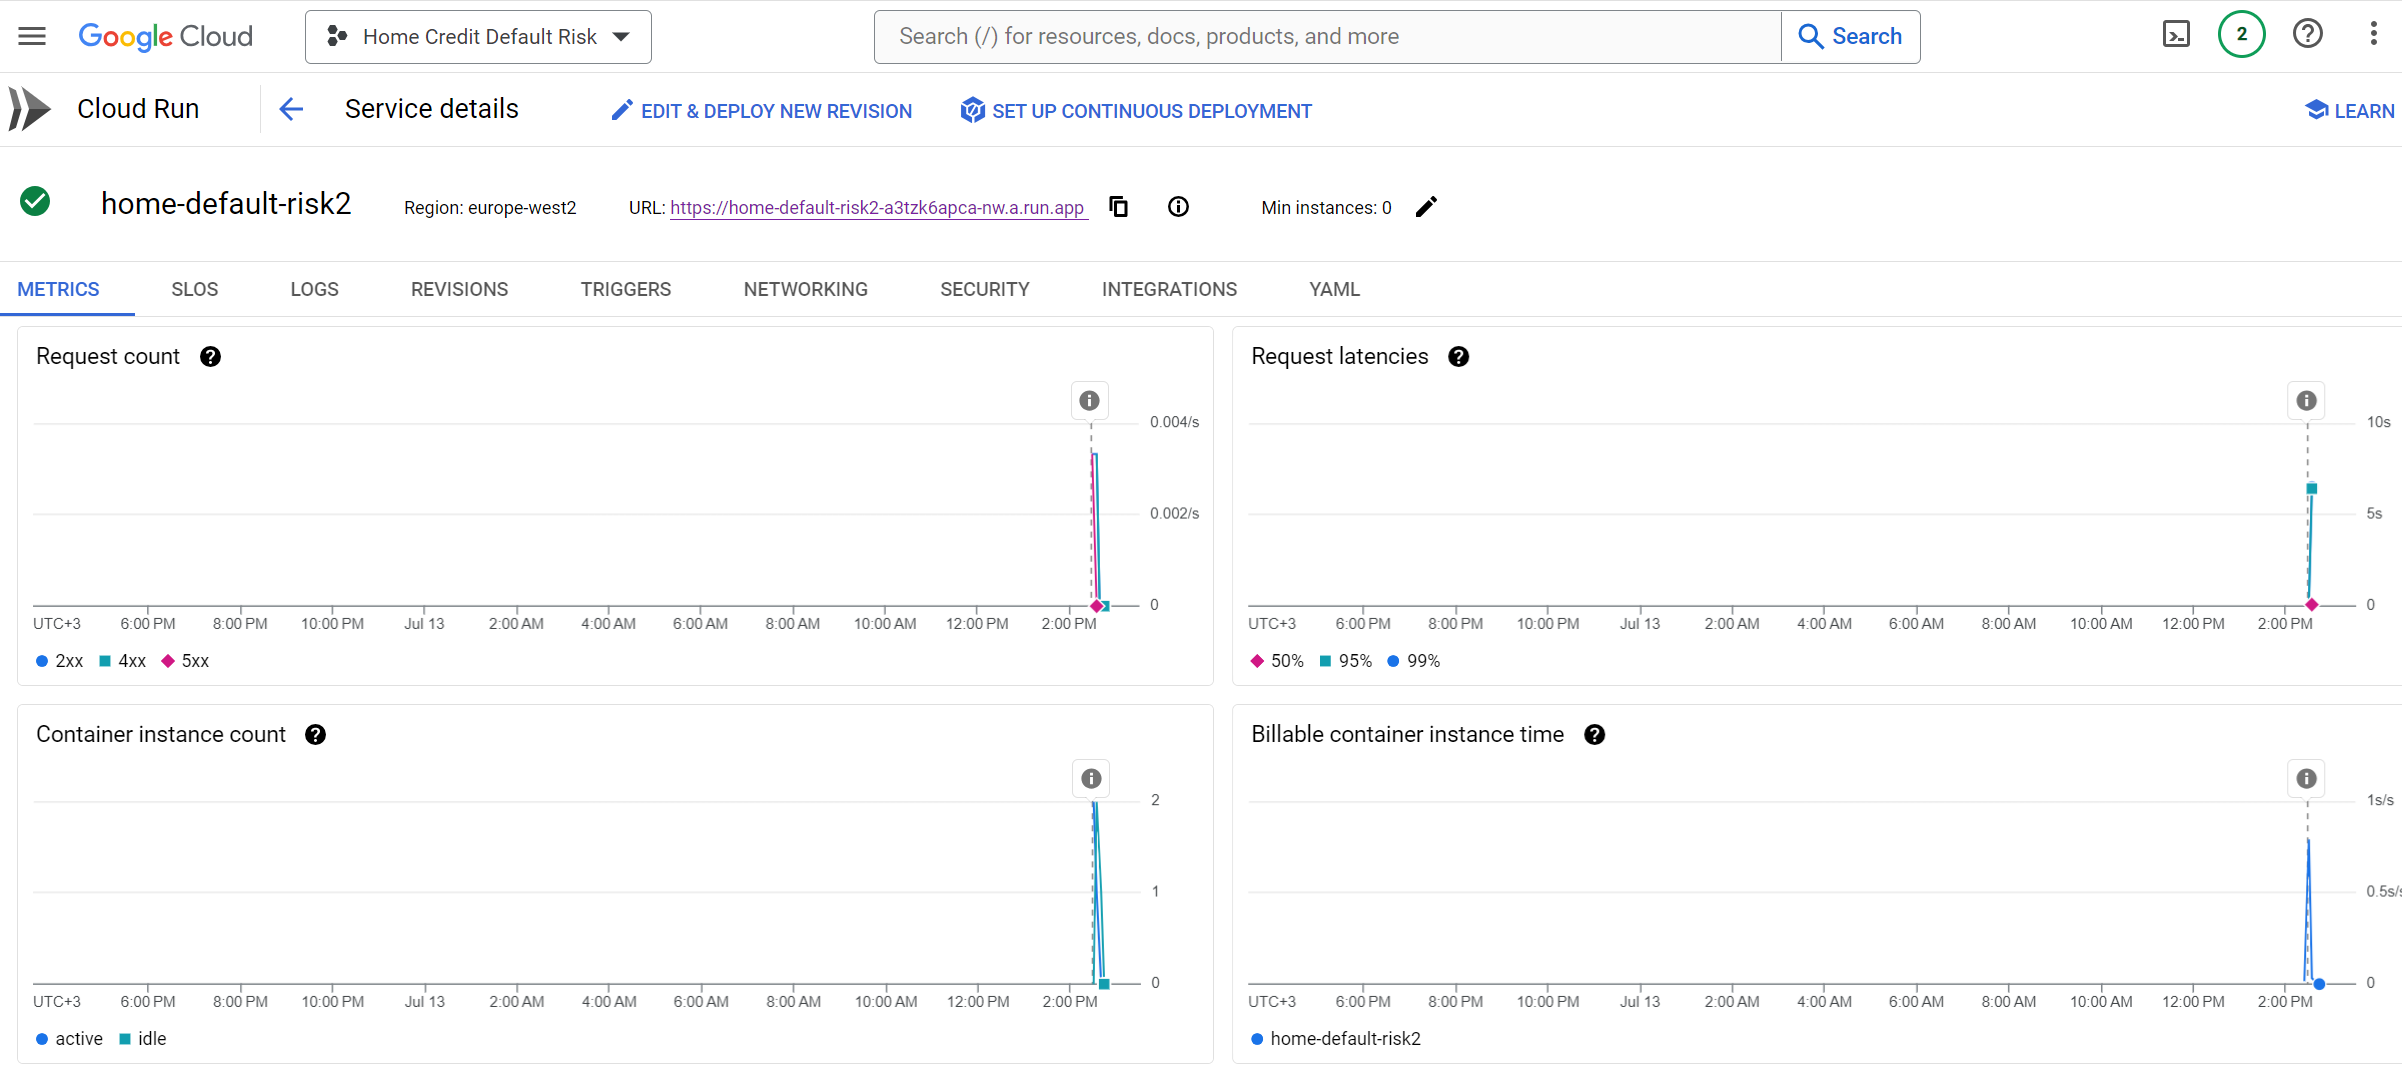

# Server Link
https://console.cloud.google.com/run/detail/europe-west2/home-default-risk2/metrics?project=glossy-reserve-429112-u9